blog post 2 - basic system stats
bikes per capita, area coverage, and zoning stats

In [1]:
# imports

import geopandas
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
sys.path.append("C:\\Users\\beezy\\git\\bluebikes_system_analysis\\code")
sys.path.append("C:\\Users\\beezy\\git\\bluebikes_system_analysis\\code\\data_handling")

# for loading station information
from data_handling.data_loading_methods import *

# useful crs constants
crs_lonlat = 'EPSG:4269'
crs_cartesian_feet = 'EPSG:2263'

part 1 - bikes per capita per city

In [2]:
# load city limits geodata
citylimits = load_MA_citylimits()

# load bluebike station geodata
stationdata = load_station_info()
# convert to a geodataframe
station_gdf = geopandas.GeoDataFrame(
    stationdata, geometry=geopandas.points_from_xy(stationdata['lon'], stationdata['lat']), crs=crs_lonlat)

In [3]:
# pick cities to load info on

CITIES = [ 'BOSTON', 'CAMBRIDGE', 'SOMERVILLE', 'BROOKLINE', 'EVERETT',
           'REVERE', 'CHELSEA', 'ARLINGTON', 'MEDFORD',
           'WATERTOWN', 'NEWTON' ]

populations = [ 689326, 117822, 81175, 59223, 46275, 
                53400, 39878, 42844, 58290, 
                35749, 88322 ]

In [4]:
# function to calculate how many bikes are in each city

def count_bikes_in_city( station_gdf, citylimits, CITY ):
    
    # find all stations in city
    city_limits = citylimits.loc[ citylimits['TOWN'] == CITY ]
    stations_incity = station_gdf.loc[ station_gdf['geometry'].map(lambda x: city_limits['geometry'].intersects(x).any() ) ]
    
    # return bike total
    return np.sum( stations_incity['capacity'] )

In [5]:
# count # of bikes in each city

biketotals_percity = [ count_bikes_in_city( station_gdf, citylimits, CITY ) for CITY in CITIES ]
bikespercapita_percity = [a/b for a,b in zip(biketotals_percity,populations)]

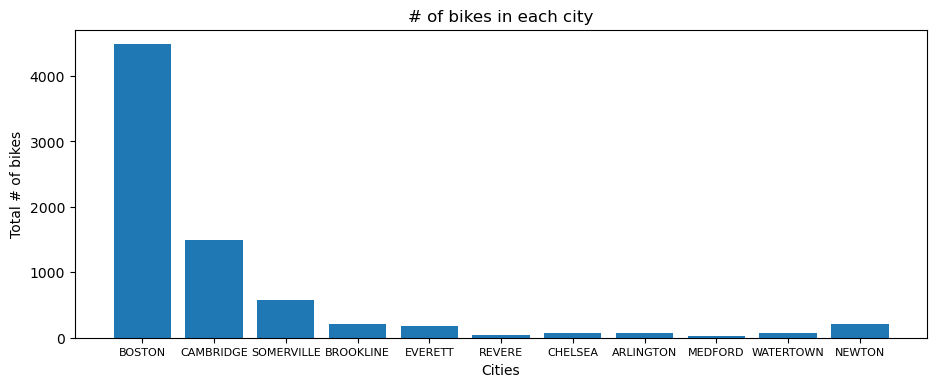

In [6]:
# plotting # of bikes per city

fig, ax = plt.subplots(figsize =(11, 4))
ax.bar( x = CITIES, 
        height = biketotals_percity)
ax.tick_params(axis='x', which='major', labelsize=8)

plt.xlabel("Cities")
plt.ylabel("Total # of bikes")
plt.title('# of bikes in each city')
    
# Show plot
plt.show()

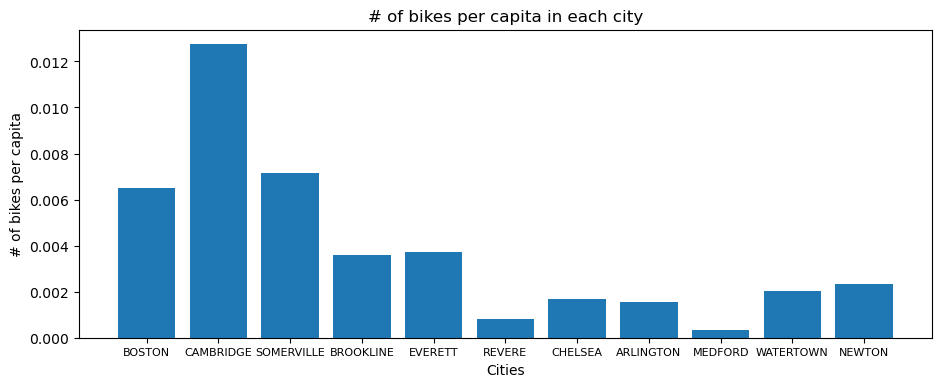

In [7]:
# plotting # of bikes per capity for each city

fig, ax = plt.subplots(figsize =(11, 4))
ax.bar( x = CITIES, 
        height = bikespercapita_percity)
ax.tick_params(axis='x', which='major', labelsize=8)

plt.xlabel("Cities")
plt.ylabel("# of bikes per capita")
plt.title('# of bikes per capita in each city')
    
# Show plot
plt.show()

part 2 - walkable coverage

In [8]:
# function to calculate area coverage by city

def calc_area_coverage(cityname, walktime):
    """
    Calculates how much area of a city is covered within <walktime> min. of a station
    
    Inputs:
        cityname: string, name of city to compare to
        walktime: float, walking time in minutes
        
    Outputs:
        percent_coverage: % coverage
        select_citylimits: geodata for selected city
        intersection_wcity: geodata for intersection data
    """
    
    # load city limits geodata
    citylimits = load_MA_citylimits()
    
    # load bluebike station geodata
    stationdata = load_station_info()
    # convert to a geodataframe
    station_gdf = geopandas.GeoDataFrame(
        stationdata, geometry=geopandas.points_from_xy(stationdata['lon'], stationdata['lat']), crs=crs_lonlat)
    
    # convert gdf CRS to cartesian
    citylimits = citylimits.to_crs(crs=crs_cartesian_feet)
    station_gdf = station_gdf.to_crs(crs=crs_cartesian_feet)

    # calc walking distance
    mph = 3.25
    fph = mph * 5280 # feet per hour
    fpm = fph / 60 # feet per minute
    walkradius = walktime * fpm
    
    # buffer
    station_gdf['walkable_region'] = station_gdf.buffer(walkradius)
    station_gdf = station_gdf.set_geometry('walkable_region')
    
    # combine all shapes into one
    station_gdf_dissolved = station_gdf.dissolve().to_crs(crs_cartesian_feet)
    
    # intersect with chosen city
    select_citylimits = citylimits.loc[ citylimits['TOWN'] == cityname ].reset_index()
    intersection_wcity = select_citylimits.intersection( station_gdf_dissolved )

    # calculate area
    intersection_area = intersection_wcity.area
    city_area = select_citylimits.area
    percent_coverage = 100 * intersection_area[0]/city_area[0]
    
    return (percent_coverage, select_citylimits, intersection_wcity)

In [9]:
# minutes and cities

walktimes = (3, 5, 10) # in minutes
cities = ('BOSTON', 'CAMBRIDGE', 'SOMERVILLE')

In [12]:
# calculate % coverage

percent_coverage = np.empty( shape = (len(walktimes),len(cities) ) ) # dimensions walktime vs city

for wt, i_wt in zip(walktimes,range(len(walktimes))):
    print('walktime ' + str(i_wt) + 'of' + str(len(walktimes)) )
    for city, i_city in zip(cities, range(len(cities))):
        (percent_coverage[i_wt][i_city], select_citylimits, intersection_wcity) = calc_area_coverage(city, wt)

In [13]:
percent_coverage

array([[30.64215179, 59.79344118, 52.44840579],
       [55.05960817, 89.82874038, 87.20358876],
       [78.01588575, 99.99885074, 98.76096628]])

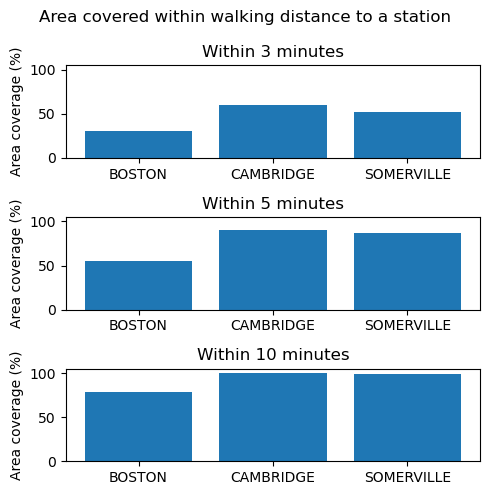

In [42]:
# Plot bar graphs of area coverage within walking distance

fig, axs = plt.subplots(len(walktimes), 1, layout='tight', figsize =(5, 5))

# set super title
fig.suptitle('Area covered within walking distance to a station')

for wt, i_wt in zip(walktimes,range(len(walktimes))):
    
    axs[i_wt].bar( x = cities, 
            height = percent_coverage[i_wt] )
#     axs[i_wt].tick_params(axis='x', which='major', labelsize=8)
    # axs[0].set_xlabel('Cities')
    axs[i_wt].set_ylabel('Area coverage (%)')
    axs[i_wt].set_title('Within ' + str(wt) + ' minutes')
    axs[i_wt].set_ylim([0,105])

# plt.xlabel("Cities")
# plt.ylabel("# of bikes per capita")
# plt.title('# of bikes per capita in each city')

# plt.xlabel("Cities")
# plt.ylabel("# of bikes per capita")
# plt.title('# of bikes per capita in each city')
    
# Show plot
plt.show()

part 3 - zoning

In [43]:
# loading zoning subdistrict data
zoningdata = load_boston_zoning_data()

In [44]:
# only keep stations in boston city limits

# city limits
citylimits = load_MA_citylimits()

# filter for stations in boston
bos_limits = citylimits.loc[ citylimits['TOWN'] == 'BOSTON' ]
is_inbos = station_gdf['geometry'].map(lambda x: bos_limits['geometry'].intersects(x).any() )
stations_inbos = station_gdf.loc[is_inbos]

In [45]:
# Find what zone each station is in

stations_inbos['Zone type'] = np.repeat( '', len(stations_inbos.index) )

for index, station in stations_inbos.iterrows():
    
    # find all zones intersecting this station
    intersects_station = zoningdata.intersects( station['geometry'] )
    
    # get zone type
    stations_inbos.loc[index, 'Zone type'] = zoningdata.loc[ intersects_station, 'Zone type' ].values[0]

# end for

C:\anaconda39\envs\geo_env4\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [46]:
# count zones and stations by zone type

# get zone types
zonetypes = zoningdata['Zone type'].unique()

# for each zone type, count # of zones and stations
zonecounts_byzone = [ sum( zoningdata['Zone type'] == zonetype ) for zonetype in zonetypes ]
zonecounts_bystation = [ sum( stations_inbos['Zone type'] == zonetype ) for zonetype in zonetypes ]

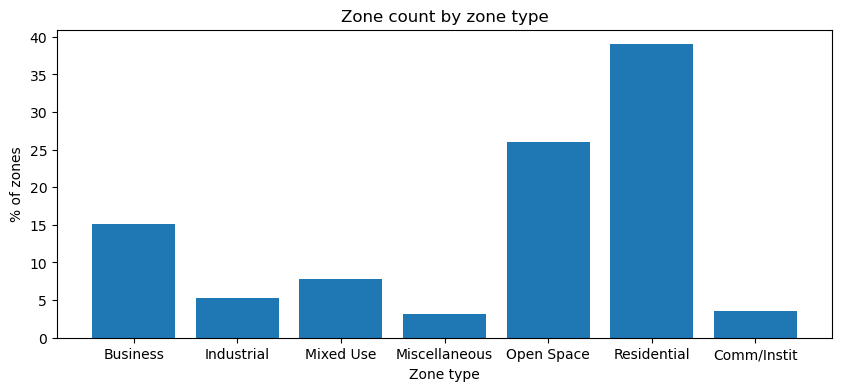

In [53]:
# bar plot of zone type counts by zone

fig, ax = plt.subplots(figsize =(10, 4))
ax.bar( x = zonetypes, 
        height = zonecounts_byzone/np.sum(zonecounts_byzone) * 100 )
 
plt.xlabel("Zone type")
plt.ylabel("% of zones")
plt.title('Zone count by zone type')
    
# Show plot
plt.show()

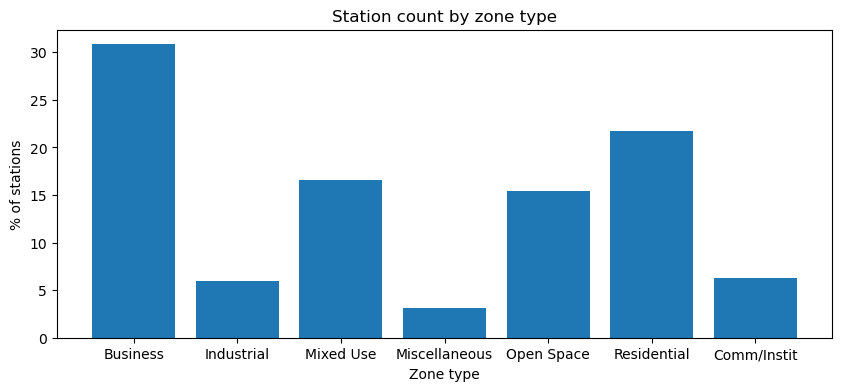

In [54]:
# bar plot of zone type counts by station

fig, ax = plt.subplots(figsize =(10, 4))
ax.bar( x = zonetypes, 
        height = zonecounts_bystation/np.sum(zonecounts_bystation) * 100 )
 
plt.xlabel("Zone type")
plt.ylabel("% of stations")
plt.title('Station count by zone type')
    
# Show plot
plt.show()